# Best Model for dataset 2

### RNN with Glove embedding

In [1]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import gensim.downloader as api
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence

In [2]:
# Load pre-trained word embeddings (GloVe)
glove_vectors = api.load("glove-wiki-gigaword-300")

In [3]:
# Define the RNN-based model with vanilla RNN layer
class RNNTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, word_embeddings):
        super(RNNTagger, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(word_embeddings, freeze=True)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        rnn_out, _ = self.rnn(embeds)
        tag_space = self.linear(rnn_out)
        return tag_space

class ReviewDataset(Dataset):
    def __init__(self, data_path, word_vectors, max_seq_length):
        self.data_path = data_path
        self.word_vectors = word_vectors
        self.max_seq_length = max_seq_length
        self.data = self.load_data()
        self.word_to_idx, self.label_to_idx = self.prepare_vocab()
        self.X, self.y = self.prepare_data()

    def load_data(self):
        with open(self.data_path, 'r') as f:
            data = json.load(f)
        return data

    def prepare_vocab(self):
        word_to_idx = {word: idx + 1 for idx, word in enumerate(self.word_vectors.index_to_key)}
        label_to_idx = {"B": 0, "I": 1, "O": 2}
        return word_to_idx, label_to_idx

    def prepare_data(self):
        X, y = [], []
        for sample in self.data.values():
            text = sample['text'].split()
            labels = sample['labels']
            text_indices = [self.word_to_idx.get(word, 0) for word in text]
            X.append(torch.tensor(text_indices))
            y.append(torch.tensor([self.label_to_idx[label] for label in labels]))
        X_padded = pad_sequence(X, batch_first=True, padding_value=0)
        y_padded = pad_sequence(y, batch_first=True, padding_value=0)
        return X_padded, y_padded

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [4]:
max_seq_length = 100
test_dataset = ReviewDataset('ATE_test.json', glove_vectors, max_seq_length)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define model parameters
embedding_dim = glove_vectors.vectors.shape[1]
vocab_size = len(glove_vectors.key_to_index) + 1  # Add 1 for the padding token
hidden_dim = 128
tagset_size = 3

In [5]:
# Load the saved model from the .pt file
loaded_model = RNNTagger(embedding_dim, hidden_dim, vocab_size, tagset_size, torch.FloatTensor(glove_vectors.vectors))
loaded_model.load_state_dict(torch.load('t2_model1_GloVe.pt'))
loaded_model.eval()

RNNTagger(
  (embedding): Embedding(400000, 300)
  (rnn): RNN(300, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=3, bias=True)
)

In [6]:
# Calculate label-wise F1 scores for the test data using the loaded model
all_preds = []
all_labels = []
with torch.no_grad():
    for text, labels in test_loader:
        outputs = loaded_model(text)
        _, predicted = torch.max(outputs, 2)
        all_preds.extend(predicted.view(-1).cpu().numpy().tolist())
        all_labels.extend(labels.view(-1).cpu().numpy().tolist())

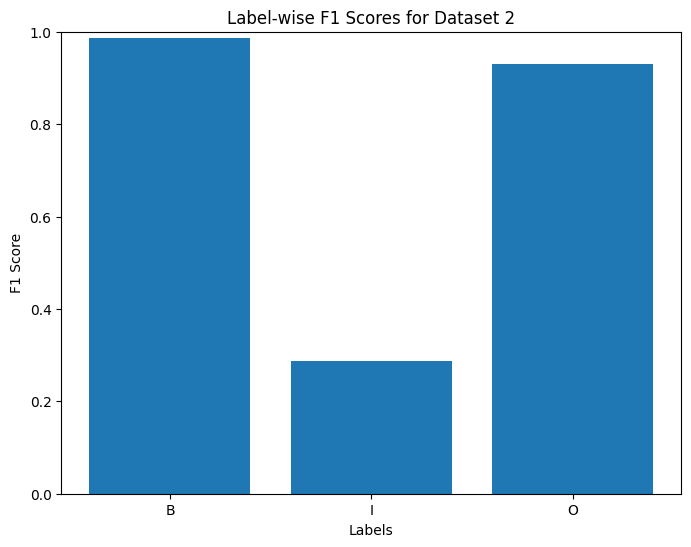

In [15]:
# Define a dictionary to decode label indices
idx_to_label = {0: "B", 1: "I", 2: "O"}

# Calculate F1 scores for each label
label_f1_scores = {}
for label_idx, label_name in idx_to_label.items():
    label_preds = [1 if pred == label_idx else 0 for pred in all_preds]
    label_labels = [1 if lbl == label_idx else 0 for lbl in all_labels]
    label_f1_scores[label_name] = f1_score(label_labels, label_preds)

# Plotting the bar graph
plt.figure(figsize=(8, 6))
plt.bar(label_f1_scores.keys(), label_f1_scores.values())
plt.xlabel('Labels')
plt.ylabel('F1 Score')
plt.title('Label-wise F1 Scores for Dataset 2')
plt.ylim(0, 1)
plt.show()


In [16]:
label_f1_scores

{'B': 0.9863903244135394, 'I': 0.28662420382165604, 'O': 0.9306675266043212}